In [23]:
# this is for redoing the LC search and splitting the plotting into  fully independent function

# imports
import numpy as np
import matplotlib as pyplot
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib as mpl
import os, sys, time, shutil
import astropy.io.fits as pyfits
import numpy as np
import re
import subprocess # for running shell commands
import sys
from tqdm import tqdm
#from swifttools.swift_too import Data
#from swifttools.swift_too import Clock, ObsQuery, VisQuery
from datetime import datetime,timedelta
import json
from astropy.stats import poisson_conf_interval
#import xspec # for spectrum models

from scipy.signal import boxcar


#test inf

time_window = 3 # seconds, length of search window
swift_id =  '00031385006'
trig_time = 643448866.0671 # str?

lc_file = 'frb.lc'
energy_bans = '15-25,25-50,50-100,100-150' 

outdir = '../resultsvn/00031385006'
evt_file = 'sw00031385006bevshpo_uf.evt'


In [24]:
# function to open out and read light curve
def get_lightcurve(outdir, evt_file, time_resolution, energy_bans):
    '''generates a lightcurve from a .evt swift/bat file
    
    args:
    
    outdir: str
            directory where the evt_file is
            
    evt_file: str
              swift/bat event file
    
    time_resolution: float, seconds
                     resolution to make light curve
    
    energy_bans: str, Kev
                 energy bans for light curve
                 example: energy_bans = '15-25,25-50,50-100,100-150' Kev
                 
    Returns: np.array(new_time), total_counts, np.array(rate), time, energy,
    
    new_time is the array in seconds of evt file data
    
    total_counts is the array of total counts 
    
    rates are the arrays of the enery ban counts
    
    time is the old time variable from the evt file
    
    energy is the old energy variable from the evt file'''
    
    # open lc file, read out data

    with fits.open(outdir + '/' + evt_file) as hdul:
        header_dict = hdul[0].header
    #hdul.info()
    
        data =hdul[1].data
        time = hdul[1].data["Time"]
        det_id = hdul[1].data['DET_ID']
        evts = hdul[1].data['EVENT_FLAGS']
        pha = hdul[1].data['PHA']
        mask_w = hdul[1].data['MASK_WEIGHT']
        detx = hdul[1].data['DETX']
        dety = hdul[1].data['DETY']
        pi = hdul[1].data['PI']
        energy = hdul[1].data['ENERGY']

        
        names = hdul[1].data.columns
    
    bins=int(np.ptp(time)/time_resolution)
    total_counts, bins = np.histogram(time, bins=bins)
    new_time = [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]
    

    bans = energy_bans.split(',')
    
    rate = np.empty((len(new_time),len(bans)))

    bins=int(np.ptp(time)/time_resolution)
    # collect counts in each energy ban
    for i in range(len(bans)):
        lower_e, upper_e = bans[i].split('-')
        lower_e, upper_e = float(lower_e), float(upper_e)
        
        good_index1 = np.where(energy >= float(lower_e))

        new_energy = energy[good_index1]
        bin_time1 = time[good_index1]

        good_index2 = np.where(new_energy <= float(upper_e))
        bin_time2 = bin_time1[good_index2]

        ban_e = new_energy[good_index2]    
       
        rate_counts_i, bins = np.histogram(bin_time2, bins=bins)

        rate[:,i] = rate_counts_i
        
    
    return np.array(new_time), total_counts, np.array(rate), time, energy, 

In [25]:
# new new lc analysis
# new lc_analysis

def lc_analysis(swift_id, trig_time, time_window, lc_file, energy_bans, outdir):

    # initalize results dict
    lc_analysis_dict = {} 
    
    
    # open lc file, read out data

    time, totcounts, rate, old_time, energy = get_lightcurve(outdir, 
                                                                              evt_file, 
                                                                              time_resolution, 
                                                                              energy_bans)
        
    # identify energy bans
    bans = energy_bans.split(',')
    
    
    
    plt.hist(totcounts, bins =30)
   # plt.yscale('log')
    plt.show()
    
    # calculate mean and noise
    totcounts_mean = np.mean(totcounts)
    totcounts_noise = np.std(totcounts)
    totcounts_snr = (totcounts-totcounts_mean) / totcounts_noise
    
    lc_analysis_dict['totcounts_dict'] = {}
    lc_analysis_dict['totcounts_dict']['snr_arr'] = totcounts_snr
    
    # indexs to cut SNR curves to search window size 
    start_i = np.where(np.abs(time - trig_time + time_window) == np.min(np.abs(time-trig_time + time_window)))[0][0]
    stop_i = np.where(np.abs(time - trig_time - time_window) == np.min(np.abs(time-trig_time - time_window)))[0][0]
    
    print('start_i, stop_i', start_i, stop_i)
    
   
    # also in rate domain
    rate_snr_dict = {} 
    lc_analysis_dict['bans_dict'] = {}
    for i in range(len(bans)):
        # double check that bans is not in reverse order
        mean_i = np.mean(rate[:,i])
        noise_i = np.std(rate[:,i])
        rate_snr_dict[bans[i]] = (rate[:,i] - mean_i ) / noise_i
        lc_analysis_dict['bans_dict'][bans[i]] = {}
        
        
        plt.figure(figsize=(12, 5))
        plt.step(time-time[0], rate[:,i],)
        plt.title('Total Count LC ' + str(bans[i]) + ' KeV', size=16)
        plt.ylabel('Counts', size=16)
        plt.xlabel('Time (s)', size=16)
        plt.show()
        
        plt.figure(figsize=(12, 5))
        plt.step(time-time[0], (rate[:,i]- np.mean(rate[:,i])) / np.std(rate[:,i]))
        plt.title('SNR LC ' + str(bans[i]) + ' KeV', size=16)
        plt.ylabel('SNR', size=16)
        plt.xlabel('Time (s)', size=16)
        plt.show()
    
    # boxcar search over SNR with varying sized boxcars
    # we want to do a sliding box car search each energy ban + the total counts arr
    # first lets move into SNR space
    
    time_res = np.logspace(-2, 0, 3) #, 0.01, 0.1, 1
    for i in tqdm(range(len(time_res)),leave=False,
                  desc='searching ' + str(len(time_res)) +' time windows'):
      
        
        time_size_per = int(np.abs((time[-1] - time[0]))) / len(time) # time size per index
        window_len = int(time_res[i] / time_size_per)
        window = boxcar(window_len)
        totcounts_convolve = np.convolve(window, totcounts_snr[start_i: stop_i])
        plt.figure(figsize=(12, 5))
        plt.plot(totcounts_convolve)
        plt.title('plot of totcounts convolution ' + 'Time Scale ' + str(time_res[i]), size=16)
        plt.show()
        
        
        
        totcounts_snr_max = np.max(totcounts_convolve) # peak from the boxcar search
        
        
        lc_analysis_dict['totcounts_dict'][time_res[i]] = totcounts_snr_max
        
        # now for each rate space SNR
        for j in range(len(bans)):
            
            bans_convolve_j = np.convolve(window, rate_snr_dict[bans[j]][start_i: stop_i])
            plt.figure(figsize=(12, 5))
            plt.plot(totcounts_convolve)
            plt.title(str(bans[j]) + ' Convolution' + 'Time Scale ' + str(time_res[i]), size=16)
            plt.show()
        
        
            bans_snr_max_j = np.max(bans_convolve_j) # peak from the boxcar search

        
            lc_analysis_dict['bans_dict'][bans[j]][time_res[i]] = bans_snr_max_j
                                     
    
    # returns dicts containg SNR, and max SNR for the boxcar search per time scale
    return lc_analysis_dict, rate_snr_dict, time, energy 

# snr seems to be higher with this method
    
    
    


In [26]:
def lc_plotting(lc_analysis_dict, rate_snr_dict, time, energy, trig_time,
                energy_bans, time_window, outdir):
    '''produces plots of the SNR for the best time scale, and plots SNR vs time scale '''
    
    
    # determine best SNR
    # I need to filter out the low SNR energy channel prior to this 
    # will be done in LC analysiss or based on the energy bands 
    # plot
    
    # indexs to cut SNR curves to search window size 
    #start_i = np.where(np.isclose(time - trig_time + time_window, 0, rtol=1e-05) == True)[0][0]
    #stop_i = np.where(np.isclose(time - trig_time - time_window, 0, rtol=1e-05) == True)[0][0]
    
    start_i = np.where(np.abs(time - trig_time + time_window) == np.min(np.abs(time-trig_time + time_window)))[0][0]
    stop_i = np.where(np.abs(time - trig_time - time_window) == np.min(np.abs(time-trig_time - time_window)))[0][0]
    
    
    
    something = plt.hist(energy, bins=int(np.sqrt(len(energy))))
    fs =15
    plt.title('Energy Distrubution of Counts', size=fs)
    plt.xlabel('KeV', size=fs)
    plt.ylabel('N', size =fs )
    plt.xlim(0, 550)

    plt.show()
    
    
    
    # plot snr vs time scale
    # how to best plot this?
    # 1 plot with different color scatters? for different enenrgy bans?
    fs = 12
    #fig = plt.figure(figsize=(8, 6))
    
    # lets loop through and grap all SNR vs time scale 
    
    time_res = []
    snr_val = []
    my_keys = list(lc_analysis_dict['totcounts_dict'].keys())
    for i in range(len(my_keys) -1):
        i += 1
        time_res.append(float(my_keys[i]))
        snr_val.append(lc_analysis_dict['totcounts_dict'][my_keys[i]])
    
    plt.scatter(time_res, snr_val, label='Total Counts')
    # now loop through energy bans
    my_keys = list(lc_analysis_dict['bans_dict'].keys())
    for i in range(len(my_keys)):
        energy_ban = my_keys[i]
        time_res_keys = list(lc_analysis_dict['bans_dict'][energy_ban].keys())
    
        time_res = []
        snr_val = []
        for j in range(len(time_res_keys)):
            time_res.append(float(time_res_keys[j]))
            snr_val.append(lc_analysis_dict['bans_dict'][energy_ban][time_res_keys[j]]) # changed to j from i 
            
        plt.scatter(time_res, snr_val, label=energy_ban + ' KeV')
    
    plt.legend(fontsize=fs, labelcolor='k')
    plt.xlabel('Time Scale (s)', fontsize=fs)
    plt.ylabel('Peak SNR', fontsize =fs)
    plt.yticks(fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.title('Time Scale vs Peak SNR', fontsize= 15)
    plt.xscale('log')
    plt.savefig('_peak_SNR_vs_time_scale.png',bbox_inches='tight')
    plt.show()
    plt.close()

    
    # plot snr tot lc vs time cutout region for search window
    snr_arr_tot = lc_analysis_dict['totcounts_dict']['snr_arr']
    
    fs = 12
    fig, ax = plt.subplots(2,figsize=(12, 12))
    plt.yticks(fontsize=fs)
    plt.xticks(fontsize=fs)
 
    
    #fig.suptitle()
    ax[0].set_title('SNR of Total Lightcurve', fontsize=15)
    ax[1].set_title('SNR of Search Window', fontsize=15)
    
    ax[0].set_xlabel('Time (s)', fontsize=fs)
    ax[0].set_ylabel('SNR', fontsize=fs)
    ax[0].step(time - time[0],snr_arr_tot)
    
    ax[1].set_xlabel('Time (s)', fontsize=fs)
    ax[1].set_ylabel('SNR', fontsize=fs)
    ax[1].step((time - time[0])[start_i:stop_i],(snr_arr_tot)[start_i:stop_i])
    
    plt.savefig(outdir +'_SNR_tot_lc.pdf',bbox_inches='tight')
    plt.show()
    plt.close()
    
    # plot the different energy bans vs time cutout region for search window
    rate_snr_keys = list(rate_snr_dict.keys())
    for i in range(len(rate_snr_keys)):
        my_key = rate_snr_keys[i]
        
        snr_arr = rate_snr_dict[my_key]
    
        fs = 12
        fig, ax = plt.subplots(2,figsize=(12, 12))
        plt.yticks(fontsize=fs)
        plt.xticks(fontsize=fs)
 
    
        #fig.suptitle()
        ax[0].set_title('SNR of ' + my_key + 'KeV Band', fontsize=15)
        ax[1].set_title('SNR of Search Window', fontsize=15)
    
        ax[0].set_xlabel('Time (s)', fontsize=fs)
        ax[0].set_ylabel('SNR', fontsize=fs)
        ax[0].plot(time - time[0],snr_arr)
    
        ax[1].set_xlabel('Time (s)', fontsize=fs)
        ax[1].set_ylabel('SNR', fontsize=fs)
        ax[1].plot((time - time[0])[start_i:stop_i],(snr_arr)[start_i:stop_i])
    
        plt.savefig(outdir +'_SNR_' + my_key + 'lc.pdf',bbox_inches='tight')
        plt.show()
        plt.close()
        
    
    

### Following 2 cells are for Runing LC analysis and plot

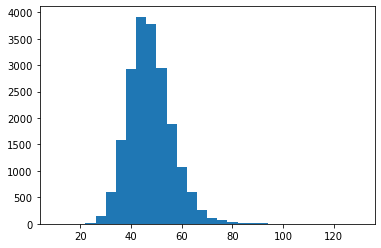

start_i, stop_i 9606 10206


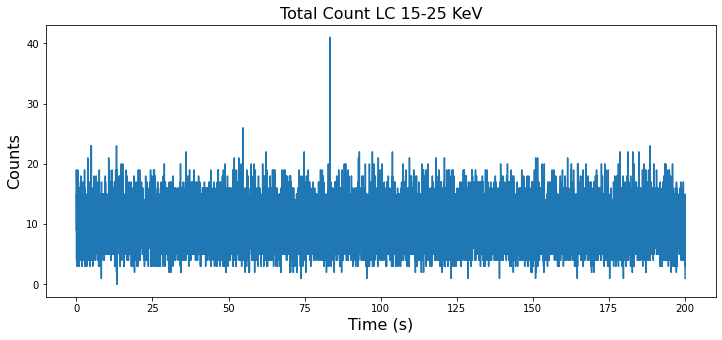

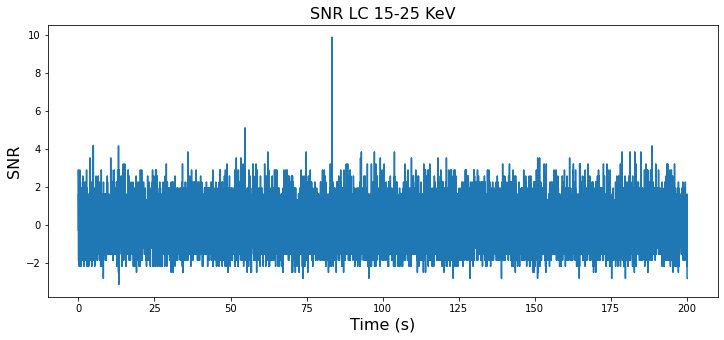

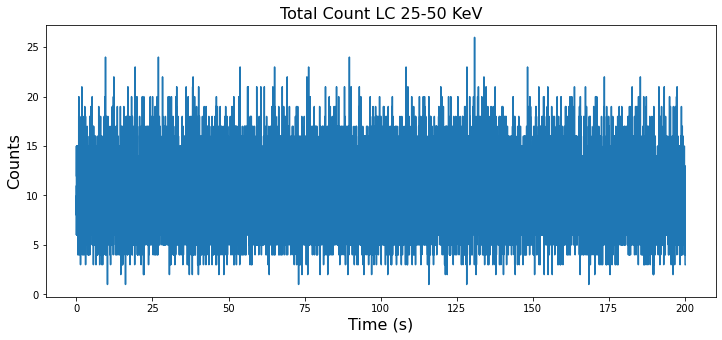

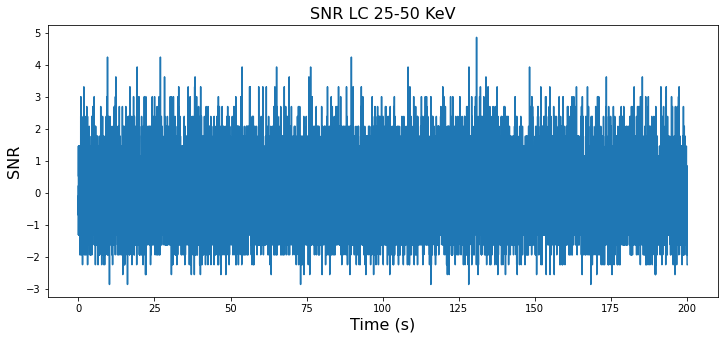

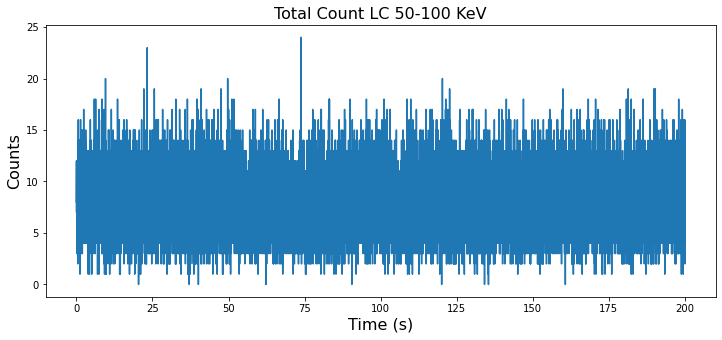

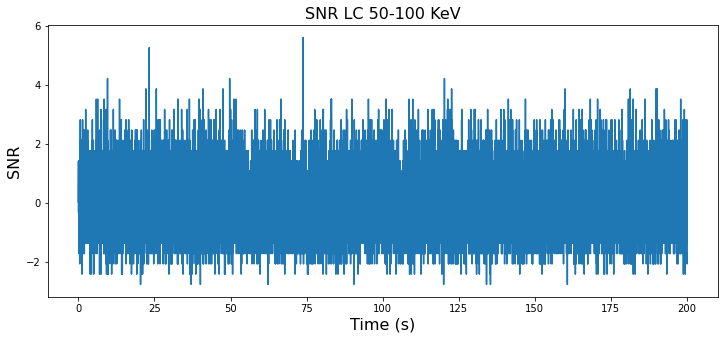

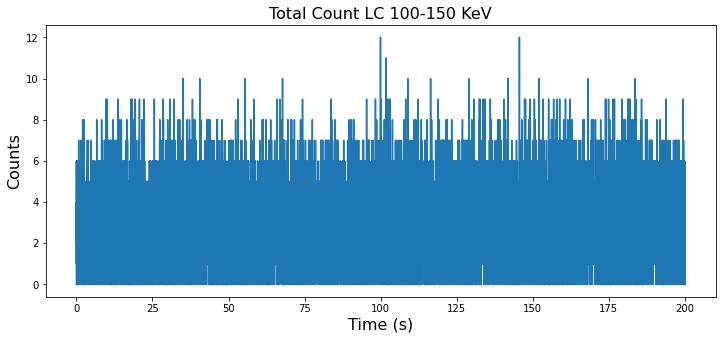

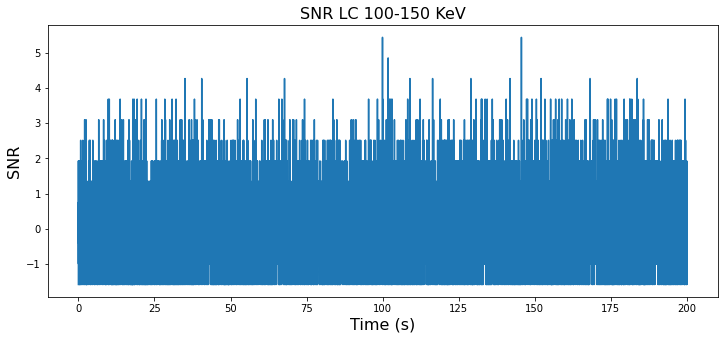

searching 3 time windows:   0%|                                                                                                                                                                | 0/3 [00:00<?, ?it/s]

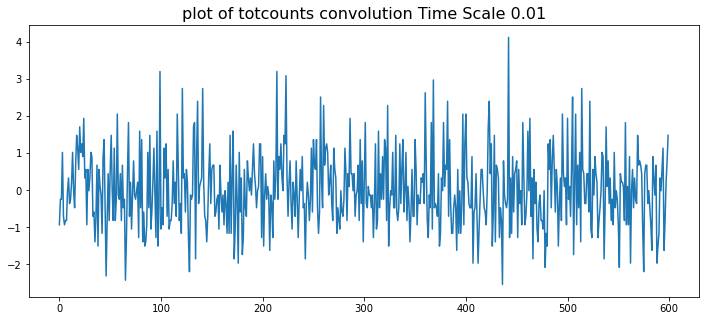

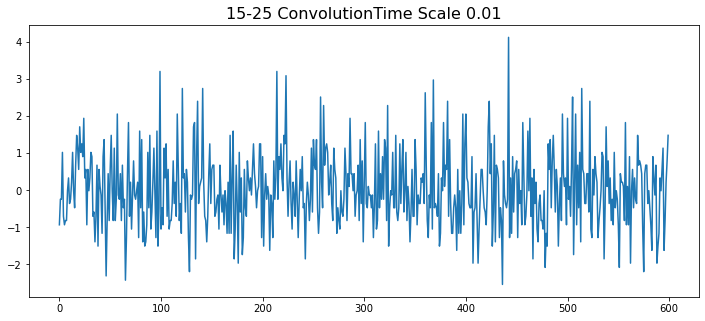

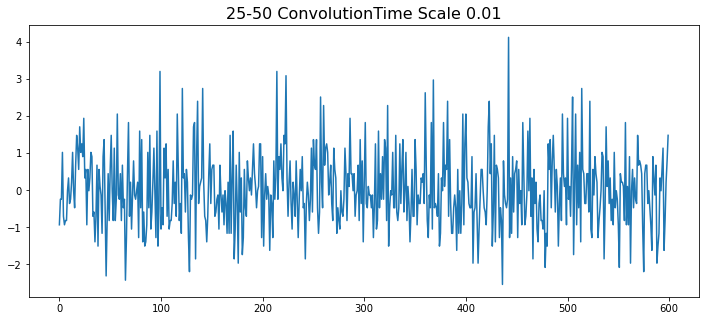

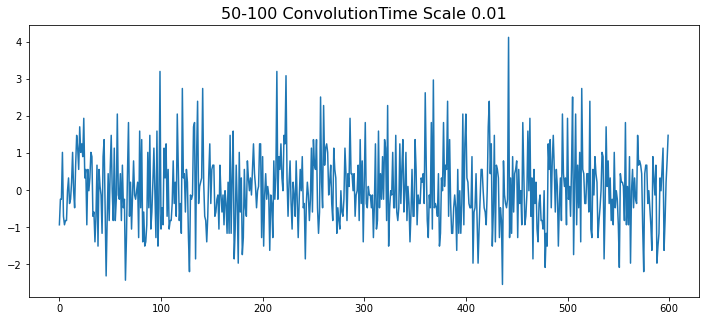

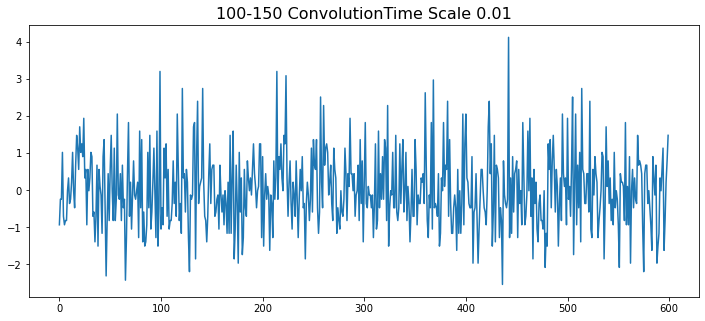

searching 3 time windows:  33%|██████████████████████████████████████████████████▋                                                                                                     | 1/3 [00:00<00:01,  1.23it/s]

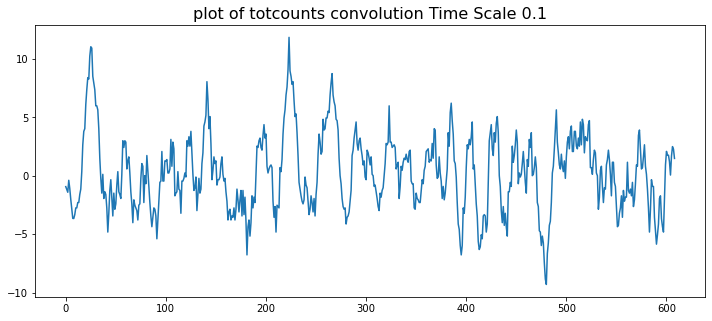

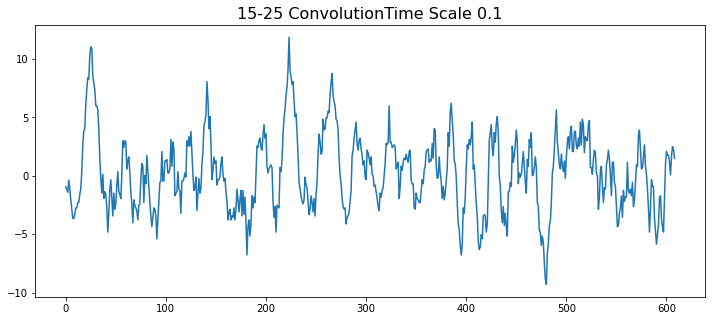

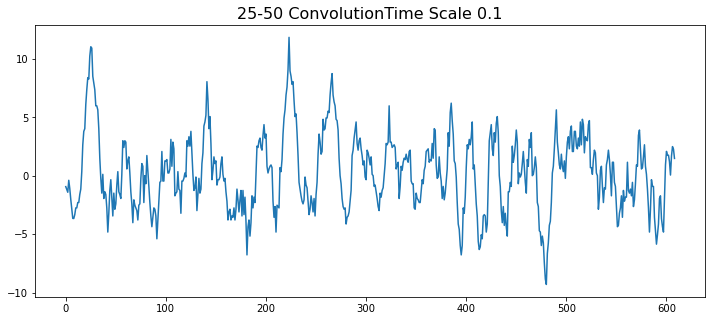

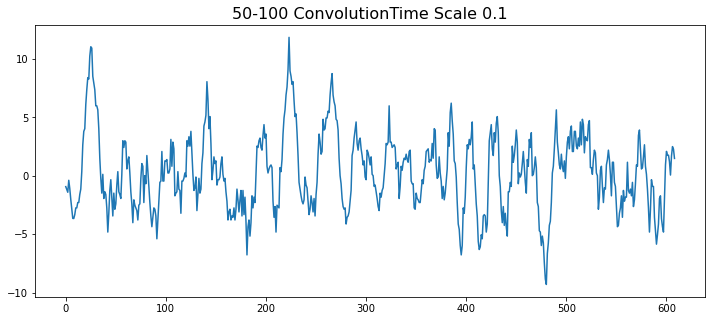

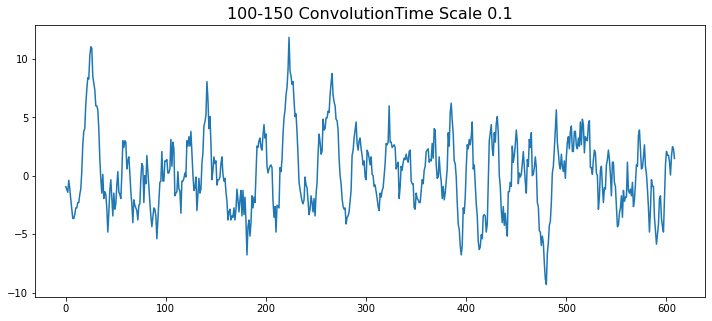

searching 3 time windows:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 2/3 [00:01<00:00,  1.67it/s]

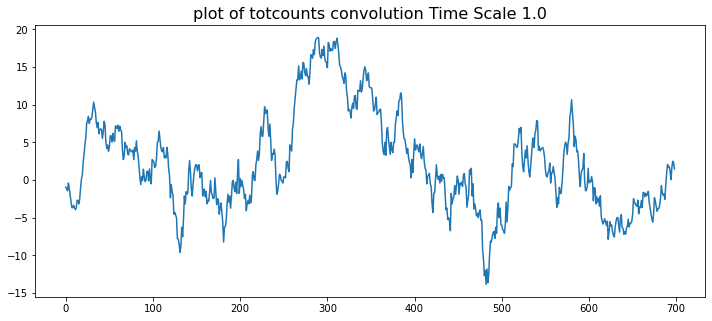

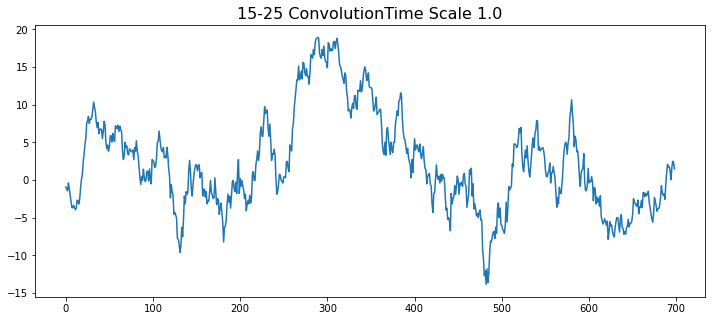

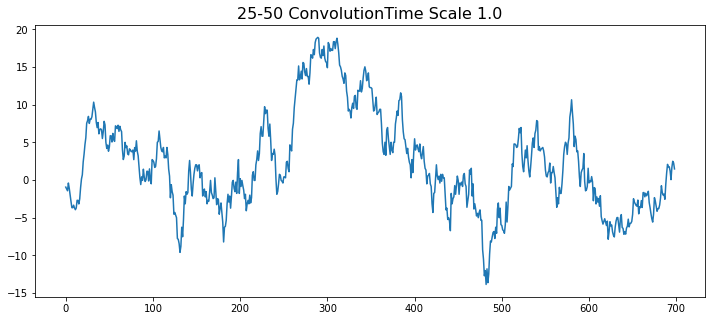

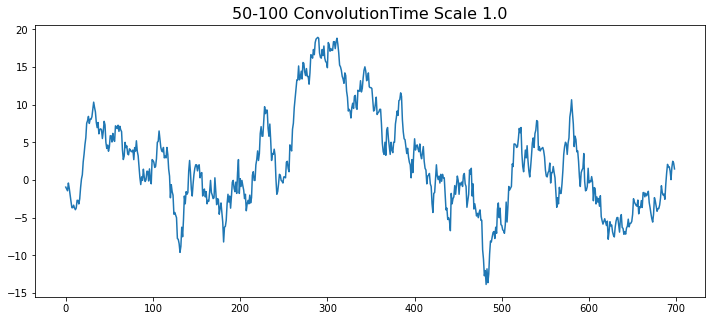

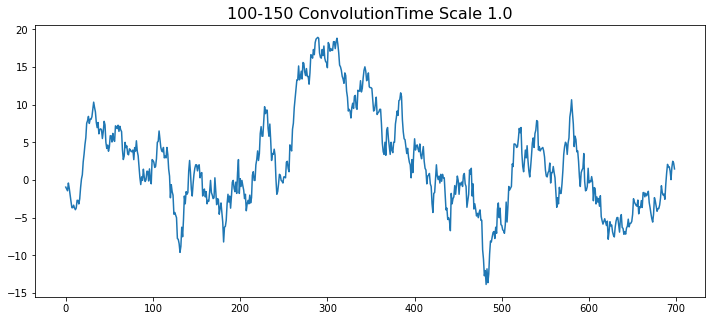

In [27]:

time_resolution = 1e-2 # for light curve
lc_analysis_dict, rate_snr_dict, time, energy = lc_analysis(swift_id, trig_time, time_window, lc_file, energy_bans, outdir)



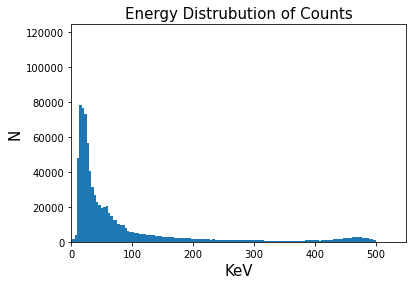

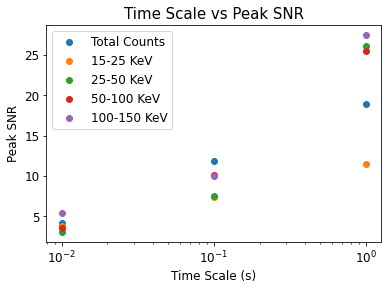

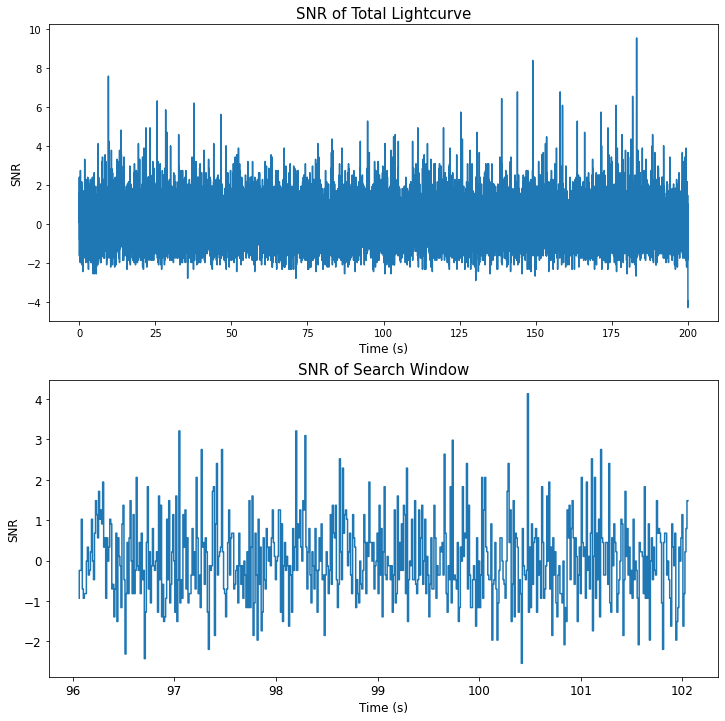

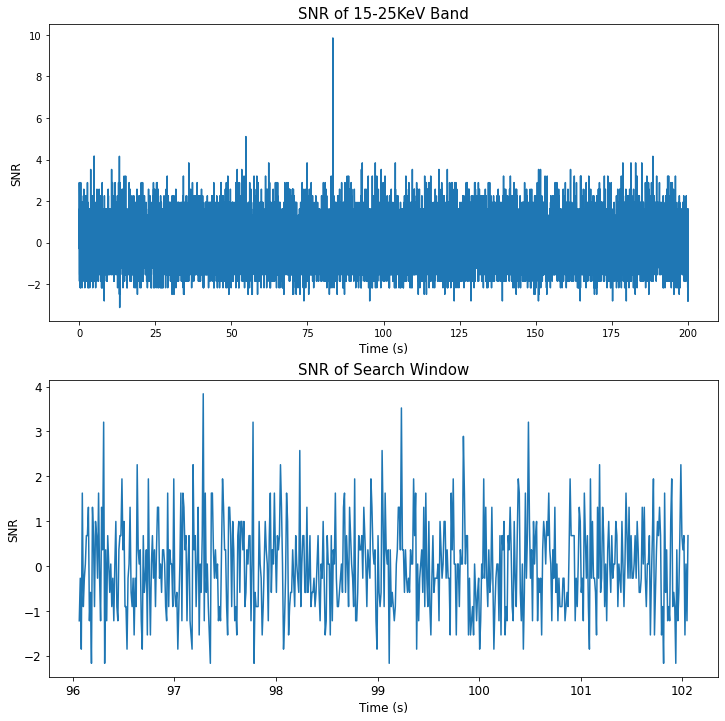

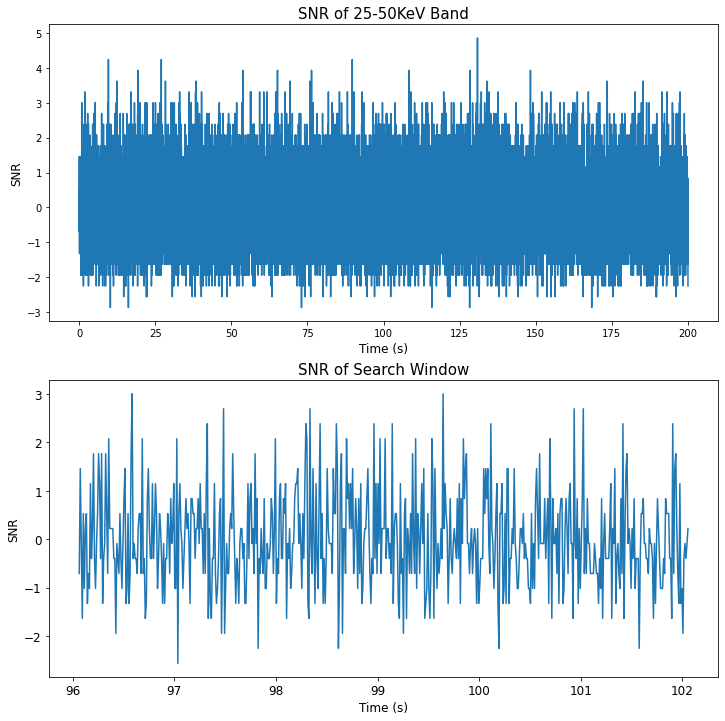

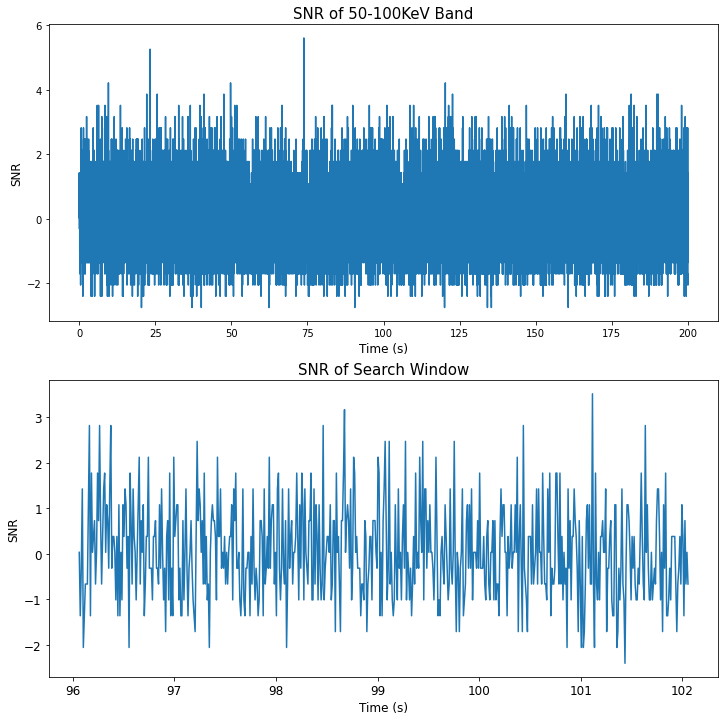

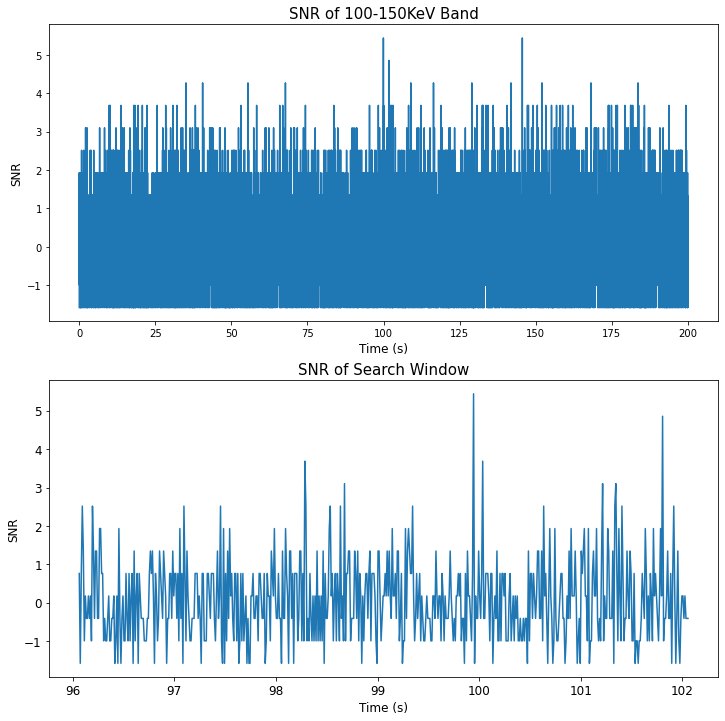

In [28]:
lc_plotting(lc_analysis_dict, rate_snr_dict, time, energy, trig_time,
                energy_bans, time_window, outdir)